# Prédiction de Matchs de Tennis ATP

## Objectif du projet

L'objectif de ce projet est de **prédire le vainqueur d'un match de tennis** en utilisant des données historiques du circuit ATP (2000-2025).

Notre baseline sera le taux de victoire du joueur le mieux classé. L'enjeu est de construire un modèle qui fait mieux que cette baseline naïve.

---

## Structure du notebook

1. **Chargement et exploration des données brutes**
2. **Preprocessing et feature engineering**
3. **Analyse approfondie des features**
4. **Modélisation et évaluation**

---

## Organisation du code

Les fonctions réutilisables sont dans le dossier `src/` :
- `src/preprocessing/cleaning.py` : chargement et nettoyage des données
- `src/preprocessing/features.py` : création des features
- `src/preprocessing/pipeline.py` : orchestration du preprocessing

Cela permet de garder ce notebook lisible en important directement les fonctions.

---

# Partie 1 : Chargement et Exploration des Données Brutes

## 1.1 Imports et configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Ajouter src/ au path pour pouvoir importer nos modules
sys.path.append(str(Path.cwd().parent / 'src'))

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1.2 Chargement des données

Les données proviennent du repository de Jeff Sackmann ([tennis_atp](https://github.com/JeffSackmann/tennis_atp)). Elles contiennent l'historique de tous les matchs ATP depuis 2000.

Nous utilisons la fonction `load_matches()` de notre module `src/preprocessing/cleaning.py` qui concatène automatiquement tous les fichiers CSV.

In [3]:
from preprocessing.cleaning import load_matches
from config import RAW_DIR

# Charger toutes les données (2000-2025)
matches = load_matches(RAW_DIR)
print(f"Nombre total de matchs : {len(matches):,}")

Nombre total de matchs : 77,939


## 1.3 Aperçu des données

Regardons la structure des données pour comprendre ce dont nous disposons.

In [4]:
# Afficher les colonnes disponibles
print("Colonnes disponibles :")
print(matches.columns.tolist())

Colonnes disponibles :
['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'indoor', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']


In [5]:
# Aperçu des premières lignes
matches.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,indoor,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-7308,Adelaide,Hard,32.0,250,O,20000103,1.0,E113,1.0,NaN,Thomas Enqvist,R,191.0,SWE,25.810,4.0,2606.0,C487,NaN,NaN,Arnaud Clement,R,173.0,FRA,22.045,56.0,805.0,6-3 6-4,3,R32,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0
1,2000-7308,Adelaide,Hard,32.0,250,O,20000103,2.0,F324,NaN,NaN,Roger Federer,R,185.0,SUI,18.404,64.0,749.0,K260,NaN,NaN,Jens Knippschild,R,191.0,GER,24.882,91.0,525.0,6-1 6-4,3,R32,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0
2,2000-7308,Adelaide,Hard,32.0,250,O,20000103,3.0,G352,NaN,NaN,Jan-Michael Gambill,R,191.0,USA,22.585,58.0,803.0,A202,NaN,NaN,Wayne Arthurs,L,185.0,AUS,28.797,105.0,449.0,3-6 7-6(5) 6-4,3,R32,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0


### Observations sur la structure des données

Chaque ligne représente un match avec :

**Informations sur le tournoi :**
- `tourney_name`, `tourney_date` : nom et date du tournoi
- `surface` : type de surface (Hard, Clay, Grass, Carpet)
- `tourney_level` : niveau du tournoi (G=Grand Slam, M=Masters, A=ATP 250/500, etc.)
- `round` : tour du tournoi (R128, R64, R32, R16, QF, SF, F)

**Informations sur les joueurs :**
- `winner_*` / `loser_*` : informations sur le gagnant et le perdant
- `_rank`, `_rank_points` : classement ATP et points
- `_age`, `_ht`, `_hand` : âge, taille, main dominante

**Statistiques du match :**
- `w_ace`, `w_df`, `w_svpt`, etc. : statistiques de service du gagnant
- `l_ace`, `l_df`, `l_svpt`, etc. : statistiques de service du perdant

## 1.4 Analyse des valeurs manquantes

Avant tout preprocessing, identifions les colonnes avec des valeurs manquantes.

In [6]:
# Pourcentage de valeurs manquantes par colonne
missing = (matches.isnull().sum() / len(matches) * 100).sort_values(ascending=False)
missing_df = missing[missing > 0].reset_index()
missing_df.columns = ['Colonne', '% Manquant']
missing_df['% Manquant'] = missing_df['% Manquant'].round(2)
missing_df

,Colonne,% Manquant
0,winner_entry,87.57
1,loser_entry,79.95
2,loser_seed,77.06
3,winner_seed,58.64
4,minutes,9.29
5,indoor,8.82
6,w_SvGms,8.24
7,w_1stIn,8.24
8,w_1stWon,8.24
9,w_2ndWon,8.24


### Observations sur les valeurs manquantes

- **`winner_entry`, `loser_entry`, `winner_seed`, `loser_seed`** : Ces colonnes ne sont remplies que pour les têtes de série. Ce n'est pas problématique car nous n'utiliserons pas ces variables.

- **Statistiques de match (`w_ace`, `l_df`, etc.)** : ~4-5% de matchs sans statistiques (probablement des matchs où les stats n'ont pas été enregistrées). Ces matchs peuvent être conservés car nous calculerons des statistiques historiques.

- **`winner_rank`, `loser_rank`** : <1% de valeurs manquantes. Nous imputerons avec une valeur par défaut (rang élevé).

- **`winner_ht`, `loser_ht`** : <1% de tailles manquantes. Nous imputerons avec la médiane.

## 1.5 Analyse des matchs incomplets

Certains matchs se terminent par abandon (RET), forfait (W/O) ou disqualification (DEF). Ces matchs ne reflètent pas la vraie force des joueurs.

In [7]:
# Identifier les matchs incomplets via le score
incomplete_patterns = ['RET', 'W/O', 'DEF', 'Walkover', 'Default']
is_incomplete = matches['score'].fillna('').str.contains('|'.join(incomplete_patterns), case=False)

n_incomplete = is_incomplete.sum()
pct_incomplete = n_incomplete / len(matches) * 100

print(f"Matchs incomplets : {n_incomplete:,} ({pct_incomplete:.2f}%)")
print("\nExemples de scores incomplets :")
matches.loc[is_incomplete, 'score'].head(10).tolist()

Matchs incomplets : 2,788 (3.58%)

Exemples de scores incomplets :


['6-4 0-1 RET',
 '6-1 RET',
 '3-6 7-5 3-0 RET',
 '7-5 3-6 1-0 RET',
 '7-6(2) 6-4 RET',
 '6-2 4-1 RET',
 '3-6 7-6(3) 6-2 4-1 RET',
 '6-4 6-4 3-6 3-1 RET',
 '6-2 2-6 6-4 3-1 RET',
 '6-0 6-7(2) 3-1 RET']

**Décision** : Nous supprimerons ces matchs incomplets car ils ne reflètent pas le vrai niveau des joueurs.

## 1.6 Distribution des surfaces

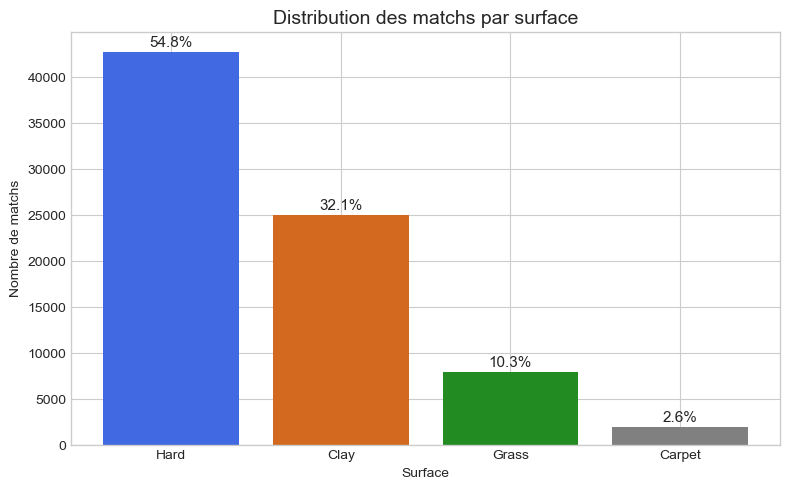

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = {'Hard': '#4169E1', 'Clay': '#D2691E', 'Grass': '#228B22', 'Carpet': '#808080'}
surface_counts = matches['surface'].value_counts()

bars = ax.bar(surface_counts.index, surface_counts.values, 
              color=[colors.get(s, '#808080') for s in surface_counts.index])

ax.set_title('Distribution des matchs par surface', fontsize=14)
ax.set_xlabel('Surface')
ax.set_ylabel('Nombre de matchs')

# Ajouter les pourcentages
for bar, count in zip(bars, surface_counts.values):
    pct = count / len(matches) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{pct:.1f}%', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

**Observation** : Le Hard est la surface dominante (~60%), suivi de la terre battue (~30%) et du gazon (~10%). Le Carpet a pratiquement disparu du circuit.

## 1.7 La baseline : le mieux classé gagne-t-il toujours ?

Calculons le taux de victoire du joueur le mieux classé. C'est notre **baseline à battre**.

In [9]:
# Filtrer les matchs avec les classements disponibles
matches_with_ranks = matches.dropna(subset=['winner_rank', 'loser_rank'])

# Le mieux classé = celui avec le rang le plus bas
better_ranked_wins = (matches_with_ranks['winner_rank'] < matches_with_ranks['loser_rank']).mean()

print(f"Le joueur le mieux classé gagne : {better_ranked_wins:.1%} des matchs")
print(f"\n→ C'est notre BASELINE à battre !")

Le joueur le mieux classé gagne : 65.4% des matchs

→ C'est notre BASELINE à battre !


## 1.8 Distribution des classements

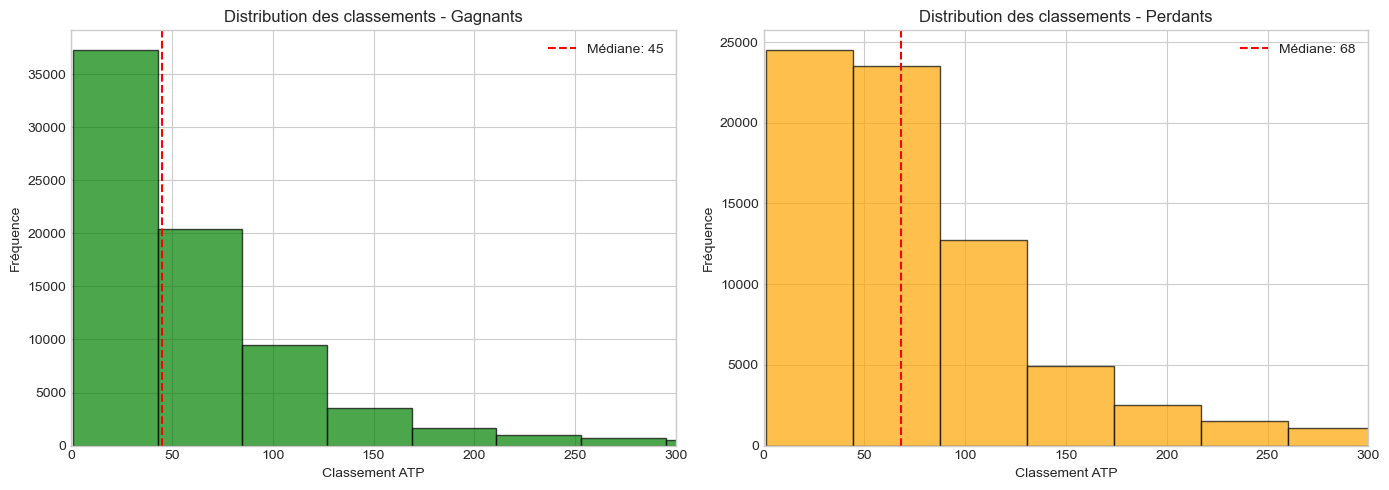

Classement médian des gagnants : 45
Classement médian des perdants : 68


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classement des gagnants
axes[0].hist(matches['winner_rank'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_title('Distribution des classements - Gagnants', fontsize=12)
axes[0].set_xlabel('Classement ATP')
axes[0].set_ylabel('Fréquence')
axes[0].set_xlim(0, 300)
axes[0].axvline(matches['winner_rank'].median(), color='red', linestyle='--', label=f"Médiane: {matches['winner_rank'].median():.0f}")
axes[0].legend()

# Classement des perdants
axes[1].hist(matches['loser_rank'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution des classements - Perdants', fontsize=12)
axes[1].set_xlabel('Classement ATP')
axes[1].set_ylabel('Fréquence')
axes[1].set_xlim(0, 300)
axes[1].axvline(matches['loser_rank'].median(), color='red', linestyle='--', label=f"Médiane: {matches['loser_rank'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Classement médian des gagnants : {matches['winner_rank'].median():.0f}")
print(f"Classement médian des perdants : {matches['loser_rank'].median():.0f}")

**Observation** : Les gagnants ont un meilleur classement que les perdants :
- Classement médian des gagnants : **45**
- Classement médian des perdants : **68**

Cela confirme l'importance du classement comme variable prédictive.

## 1.9 Niveaux de tournois

In [11]:
# Décoder les niveaux de tournoi
level_names = {
    'G': 'Grand Slam',
    'M': 'Masters 1000',
    'A': 'ATP 250/500',
    'D': 'Davis Cup',
    'F': 'ATP Finals',
    'O': 'Olympics'
}

level_counts = matches['tourney_level'].value_counts()
level_df = pd.DataFrame({
    'Niveau': [level_names.get(l, l) for l in level_counts.index],
    'Code': level_counts.index,
    'Nombre de matchs': level_counts.values,
    '%': (level_counts.values / len(matches) * 100).round(1)
})
level_df

,Niveau,Code,Nombre de matchs,%
0,250,250,30706,39.4
1,Masters 1000,M,14774,19.0
2,Grand Slam,G,13081,16.8
3,500,500,10378,13.3
4,Davis Cup,D,7331,9.4
5,ATP 250/500,A,815,1.0
6,Olympics,O,448,0.6
7,ATP Finals,F,406,0.5


---

## 1.10 Conclusion de l'exploration

### Ce que nous avons appris :

1. **77,939 matchs** sur 25 ans de données ATP (2000-2025)
2. **Baseline** : le mieux classé gagne **65.4%** du temps
3. **Surfaces** : Hard domine (60%), suivi de Clay (30%) et Grass (10%)
4. **Valeurs manquantes** : peu problématiques (<5% pour les variables importantes)
5. **Matchs incomplets** : 2,788 matchs (~3.6%) à supprimer (RET, W/O, DEF)

### Plan de preprocessing :

1. **Nettoyage** :
   - Supprimer les matchs incomplets (RET, W/O, DEF)
   - Convertir les dates
   - Imputer les valeurs manquantes (rangs, tailles)

2. **Feature engineering** :
   - Variables statiques : classement, points, âge, taille
   - Variables historiques : win rate, ace rate, etc. (calculées sur les N derniers matchs)
   - Variables spécifiques : win rate par surface, head-to-head
   - Application d'un **decay temporel** pour donner plus de poids aux matchs récents

---

# Partie 2 : Preprocessing et Feature Engineering

Dans cette partie, nous allons :
1. Nettoyer les données brutes
2. Créer des features pertinentes pour prédire le vainqueur
3. Appliquer un decay temporel pour pondérer les matchs récents

## 2.1 Nettoyage des données

Nous utilisons la fonction `clean_matches()` de `src/preprocessing/cleaning.py` qui effectue les opérations suivantes :

1. **Suppression des matchs incomplets** : RET, W/O, DEF
2. **Conversion des dates** : format datetime
3. **Imputation des classements manquants** : rang max + 50
4. **Imputation des données physiques manquantes** : médiane pour la taille et l'âge

In [12]:
from preprocessing.cleaning import clean_matches

# Appliquer le nettoyage
matches_clean = clean_matches(matches)

print(f"Avant nettoyage : {len(matches):,} matchs")
print(f"Après nettoyage : {len(matches_clean):,} matchs")
print(f"Matchs supprimés : {len(matches) - len(matches_clean):,} ({(len(matches) - len(matches_clean)) / len(matches) * 100:.1f}%)")

Avant nettoyage : 77,939 matchs
Après nettoyage : 75,016 matchs
Matchs supprimés : 2,923 (3.8%)


In [13]:
# Vérifier qu'il n'y a plus de valeurs manquantes dans les colonnes clés
key_cols = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 'tourney_date']
print("Valeurs manquantes dans les colonnes clés après nettoyage :")
print(matches_clean[key_cols].isnull().sum())

Valeurs manquantes dans les colonnes clés après nettoyage :
winner_rank     0
loser_rank      0
winner_age      0
loser_age       0
winner_ht       0
loser_ht        0
tourney_date    0
dtype: int64


## 2.2 Feature Engineering : Approche conceptuelle

### Le défi de la prédiction de matchs de tennis

Pour prédire le vainqueur d'un match, nous devons transformer les données brutes en features comparant les deux joueurs. 

**Problème** : Les données sont au format `winner_*` / `loser_*`, ce qui crée un biais (le gagnant a toujours de meilleures stats dans le match). 

**Solution** : Nous randomisons l'attribution des joueurs en `player_a` / `player_b` et utilisons uniquement des **statistiques calculées AVANT le match** (historique des matchs précédents).

### Types de features créées

| Catégorie | Features | Description |
|-----------|----------|-------------|
| **Statiques** | `rank_a`, `rank_b`, `points_a`, `points_b` | Classement et points ATP au moment du match |
| **Physiques** | `age_a`, `age_b`, `height_a`, `height_b`, `is_left_a`, `is_left_b` | Caractéristiques physiques |
| **Historiques** | `win_rate_a`, `ace_rate_a`, `df_rate_a`, etc. | Stats calculées sur les N derniers matchs |
| **Surface** | `surface_win_rate_a`, `surface_win_rate_b` | Win rate spécifique à la surface |
| **Head-to-head** | `h2h_win_rate_a` | Historique des confrontations directes |
| **Ratio** | `rank_ratio` | Ratio des classements (non-linéaire) |

### Decay temporel

Les matchs récents sont plus informatifs que les anciens. Nous appliquons un **decay exponentiel** avec une demi-vie de 180 jours :

$$w_i = e^{-\frac{\Delta t_i}{\text{half\_life}}}$$

Ainsi, un match joué il y a 180 jours compte pour 50% d'un match joué aujourd'hui.

## 2.3 Construction de l'historique des joueurs

Avant de créer les features, nous construisons un dictionnaire contenant l'historique complet de chaque joueur. Cela permet de calculer rapidement les statistiques pour n'importe quel match.

La fonction `build_player_history()` de `src/preprocessing/features.py` parcourt tous les matchs et stocke pour chaque joueur :
- La date du match
- La surface
- L'adversaire
- Le résultat (victoire/défaite)
- Les statistiques de service (aces, double fautes, etc.)

In [14]:
from preprocessing.features import build_player_history

# Construire l'historique de tous les joueurs
player_history = build_player_history(matches_clean)

# Statistiques sur l'historique
n_players = len(player_history)
avg_matches = np.mean([len(h) for h in player_history.values()])

print(f"Nombre de joueurs uniques : {n_players:,}")
print(f"Nombre moyen de matchs par joueur : {avg_matches:.1f}")

Nombre de joueurs uniques : 2,705
Nombre moyen de matchs par joueur : 55.5


In [34]:
# Exemple : historique d'un joueur (Nadal - ID 104745)
nadal_id = 'N409'
if nadal_id in player_history:
    print(f"Exemple : 3 derniers matchs de Nadal dans l'historique\n")
    for match in player_history[nadal_id][-3:]:
        print(f"  Date: {match['date']}, Surface: {match['surface']}, "
              f"Victoire: {'Oui' if match['won'] else 'Non'}, Aces: {match.get('ace', 'N/A')}")

Exemple : 3 derniers matchs de Nadal dans l'historique

  Date: 2024-07-29 00:00:00, Surface: Clay, Victoire: Oui, Aces: 1.0
  Date: 2024-07-29 00:00:00, Surface: Clay, Victoire: Non, Aces: 1.0
  Date: 2024-11-19 00:00:00, Surface: Hard, Victoire: Non, Aces: 2.0


## 2.4 Création des features

Nous utilisons la fonction `create_features()` de `src/preprocessing/features.py` qui :

1. **Randomise** l'attribution winner/loser → player_a/player_b
2. **Extrait** les features statiques (rang, points, âge, taille)
3. **Calcule** les features historiques avec decay temporel
4. **Crée** la variable cible : `target = 1` si player_a gagne, `0` sinon

### Paramètres utilisés

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| `N_HISTORICAL_MATCHES` | 10 | Nombre de matchs pour les stats générales |
| `N_SURFACE_MATCHES` | 20 | Nombre de matchs pour les stats par surface |
| `HALF_LIFE_DAYS` | 180 | Demi-vie du decay temporel (en jours) |

In [16]:
from preprocessing.features import create_features
from config import N_HISTORICAL_MATCHES, N_SURFACE_MATCHES, HALF_LIFE_DAYS, RANDOM_STATE

# Créer un générateur aléatoire pour la reproductibilité
rng = np.random.default_rng(RANDOM_STATE)

# Créer les features
print("Création des features en cours...")
features_df = create_features(
    matches_clean, 
    player_history, 
    n_hist=N_HISTORICAL_MATCHES, 
    n_surf=N_SURFACE_MATCHES, 
    rng=rng,
    half_life_days=HALF_LIFE_DAYS
)

print(f"\nDataset créé : {features_df.shape[0]:,} matchs × {features_df.shape[1]} colonnes")

Création des features en cours...

Dataset créé : 75,016 matchs × 35 colonnes


In [17]:
# Aperçu des features créées
print("Features créées :")
print(features_df.columns.tolist())

Features créées :
['target', 'rank_a', 'rank_b', 'points_a', 'points_b', 'age_a', 'age_b', 'height_a', 'height_b', 'is_left_a', 'is_left_b', 'surface', 'tourney_level', 'best_of_5', 'round', 'rank_ratio', 'win_rate_a', 'ace_rate_a', 'df_rate_a', 'first_serve_pct_a', 'first_serve_won_a', 'second_serve_won_a', 'bp_save_rate_a', 'matches_played_a', 'win_rate_b', 'ace_rate_b', 'df_rate_b', 'first_serve_pct_b', 'first_serve_won_b', 'second_serve_won_b', 'bp_save_rate_b', 'matches_played_b', 'surface_win_rate_a', 'surface_win_rate_b', 'h2h_win_rate_a']


In [18]:
# Aperçu des premières lignes
features_df.head()

,target,rank_a,rank_b,points_a,points_b,age_a,age_b,height_a,height_b,is_left_a,is_left_b,surface,tourney_level,best_of_5,round,rank_ratio,win_rate_a,ace_rate_a,df_rate_a,first_serve_pct_a,first_serve_won_a,second_serve_won_a,bp_save_rate_a,matches_played_a,win_rate_b,ace_rate_b,df_rate_b,first_serve_pct_b,first_serve_won_b,second_serve_won_b,bp_save_rate_b,matches_played_b,surface_win_rate_a,surface_win_rate_b,h2h_win_rate_a
0,0,56.0,4.0,805.0,2606.0,22.045,25.810,173.0,191.0,0,0,Hard,250,0,R32,14.000000,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.70,0.08,0.02,0.65,0.75,0.55,0.65,0,0.5,0.5,0.5
1,1,64.0,91.0,749.0,525.0,18.404,24.882,185.0,191.0,0,0,Hard,250,0,R32,0.703297,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.5,0.5,0.5
2,0,105.0,58.0,449.0,803.0,28.797,22.585,185.0,191.0,1,0,Hard,250,0,R32,1.810345,0.45,0.04,0.04,0.58,0.68,0.48,0.58,0,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.5,0.5,0.5
3,0,54.0,27.0,845.0,1298.0,23.710,21.599,180.0,175.0,0,0,Hard,250,0,R32,2.000000,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.55,0.06,0.03,0.62,0.72,0.52,0.62,0,0.5,0.5,0.5
4,1,15.0,154.0,1748.0,297.0,23.595,25.580,188.0,175.0,0,1,Hard,250,0,R32,0.097403,0.55,0.06,0.03,0.62,0.72,0.52,0.62,0,0.45,0.04,0.04,0.58,0.68,0.48,0.58,0,0.5,0.5,0.5


### Description des features créées

| Feature | Description |
|---------|-------------|
| `target` | Variable cible : 1 si player_a gagne, 0 sinon |
| `rank_a`, `rank_b` | Classement ATP des joueurs |
| `points_a`, `points_b` | Points ATP des joueurs |
| `age_a`, `age_b` | Âge des joueurs |
| `height_a`, `height_b` | Taille des joueurs (cm) |
| `is_left_a`, `is_left_b` | 1 si gaucher, 0 si droitier |
| `rank_ratio` | `rank_a / rank_b` (ratio non-linéaire) |
| `win_rate_a`, `win_rate_b` | Taux de victoire pondéré (10 derniers matchs) |
| `ace_rate_a`, `ace_rate_b` | Aces par point de service |
| `df_rate_a`, `df_rate_b` | Double fautes par point de service |
| `first_serve_pct_a/b` | % de premières balles passées |
| `first_serve_won_a/b` | % de points gagnés sur 1ère balle |
| `second_serve_won_a/b` | % de points gagnés sur 2ème balle |
| `bp_save_rate_a/b` | % de balles de break sauvées |
| `matches_played_a/b` | Nombre de matchs récents (expérience) |
| `surface_win_rate_a/b` | Win rate sur la surface du match |
| `h2h_win_rate_a` | % de victoires de A contre B (historique) |
| `surface` | Type de surface (Hard, Clay, Grass) |
| `tourney_level` | Niveau du tournoi (G, M, 500, 250, etc.) |
| `round` | Tour du tournoi (R128, R64, ..., F) |
| `best_of_5` | 1 si match en 5 sets, 0 si en 3 sets |

## 2.5 Vérification de la variable cible

Grâce à la randomisation player_a/player_b, la variable cible devrait être équilibrée (~50/50).

In [19]:
# Vérifier l'équilibre de la variable cible
target_counts = features_df['target'].value_counts()
print("Distribution de la variable cible :")
print(f"  Player A gagne (target=1) : {target_counts.get(1, 0):,} ({target_counts.get(1, 0) / len(features_df) * 100:.1f}%)")
print(f"  Player B gagne (target=0) : {target_counts.get(0, 0):,} ({target_counts.get(0, 0) / len(features_df) * 100:.1f}%)")
print(f"\n✓ La randomisation fonctionne correctement : les classes sont équilibrées.")

Distribution de la variable cible :
  Player A gagne (target=1) : 37,297 (49.7%)
  Player B gagne (target=0) : 37,719 (50.3%)

✓ La randomisation fonctionne correctement : les classes sont équilibrées.


## 2.6 Encodage des variables catégorielles

Les variables catégorielles (`surface`, `tourney_level`, `round`) doivent être encodées en variables numériques.

Nous utilisons le **one-hot encoding** avec `drop_first=True` pour éviter la multicolinéarité (dummy variable trap).

Par exemple, pour `surface` avec 4 catégories (Carpet, Clay, Grass, Hard) :
- On crée 3 colonnes binaires : `surface_Clay`, `surface_Grass`, `surface_Hard`
- `Carpet` devient la catégorie de référence (toutes les colonnes = 0)

In [20]:
# Appliquer le one-hot encoding
categorical_cols = ['surface', 'tourney_level', 'round']

features_encoded = features_df.copy()
for col in categorical_cols:
    if col in features_encoded.columns:
        dummies = pd.get_dummies(features_encoded[col], prefix=col, drop_first=True)
        features_encoded = pd.concat([features_encoded.drop(columns=[col]), dummies], axis=1)

print(f"Après encodage : {features_encoded.shape[1]} colonnes")
print(f"\nNouvelles colonnes créées :")
new_cols = [c for c in features_encoded.columns if any(c.startswith(p + '_') for p in categorical_cols)]
print(new_cols)

Après encodage : 51 colonnes

Nouvelles colonnes créées :
['surface_win_rate_a', 'surface_win_rate_b', 'surface_Clay', 'surface_Grass', 'surface_Hard', 'tourney_level_500', 'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 'tourney_level_O', 'round_BR', 'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF']


## 2.7 Vérification finale des données

In [21]:
# Vérifier qu'il n'y a pas de valeurs manquantes
missing_count = features_encoded.isnull().sum().sum()
print(f"Valeurs manquantes totales : {missing_count}")

# Vérifier les types de données
print(f"\nTypes de données :")
print(features_encoded.dtypes.value_counts())

Valeurs manquantes totales : 0

Types de données :
float64    26
bool       19
int64       6
Name: count, dtype: int64


In [22]:
# Statistiques descriptives des features numériques principales
main_features = ['rank_a', 'rank_b', 'points_a', 'points_b', 'win_rate_a', 'win_rate_b', 
                 'surface_win_rate_a', 'surface_win_rate_b', 'h2h_win_rate_a']
features_encoded[main_features].describe().round(3)

,rank_a,rank_b,points_a,points_b,win_rate_a,win_rate_b,surface_win_rate_a,surface_win_rate_b,h2h_win_rate_a
count,75016.000,75016.000,75016.000,75016.000,75016.000,75016.000,75016.000,75016.000,75016.000
mean,127.197,127.167,1286.894,1289.487,0.471,0.472,0.481,0.481,0.501
std,295.526,294.453,1659.878,1662.286,0.210,0.210,0.217,0.219,0.307
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,26.000,26.000,484.000,484.000,0.331,0.331,0.365,0.363,0.500
50%,57.000,57.000,808.000,808.000,0.485,0.487,0.500,0.500,0.500
75%,103.000,103.000,1370.000,1380.000,0.605,0.605,0.620,0.621,0.500
max,2209.000,2209.000,16950.000,16950.000,1.000,1.000,1.000,1.000,1.000


---

## 2.8 Conclusion du preprocessing

### Récapitulatif des transformations effectuées :

1. **Nettoyage** : suppression de 2,923 matchs incomplets (3.8%)
2. **Construction de l'historique** : 2,705 joueurs, ~55 matchs/joueur en moyenne
3. **Feature engineering** :
   - Features statiques (rang, points, âge, taille)
   - Features historiques avec decay temporel (win rate, stats de service)
   - Features spécifiques (surface win rate, head-to-head)
4. **Encodage** : one-hot encoding avec `drop_first=True`

### Dataset final :

| Métrique | Valeur |
|----------|--------|
| Nombre de matchs | 75,016 |
| Nombre de features | 50 (après encodage) |
| Valeurs manquantes | 0 |
| Balance des classes | 49.7% / 50.3% |

Le dataset est maintenant prêt pour l'analyse approfondie des features (Partie 3) puis la modélisation (Partie 4).

---

# Partie 3 : Analyse Approfondie des Features

Avant de modéliser, analysons les features créées pour :
1. Vérifier leur pertinence par rapport à la variable cible
2. Identifier les corrélations entre features
3. Justifier nos choix de variables

## 3.1 Matrice de corrélation des features principales

Visualisons les corrélations entre les features numériques les plus importantes.

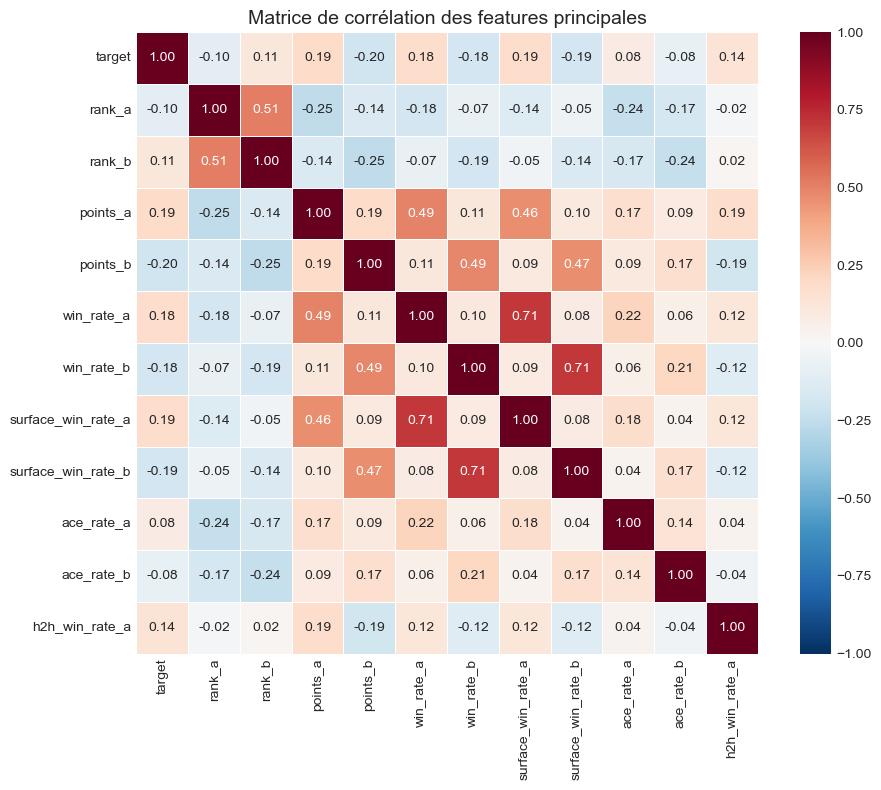

In [23]:
# Sélectionner les features principales pour la corrélation
corr_features = ['target', 'rank_a', 'rank_b', 'points_a', 'points_b', 
                 'win_rate_a', 'win_rate_b', 'surface_win_rate_a', 'surface_win_rate_b',
                 'ace_rate_a', 'ace_rate_b', 'h2h_win_rate_a']

corr_matrix = features_encoded[corr_features].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Matrice de corrélation des features principales', fontsize=14)
plt.tight_layout()
plt.show()

### Observations sur les corrélations

**Corrélations avec la target :**
- `rank_a` est négativement corrélé avec target (rang bas = meilleur = plus de victoires)
- `rank_b` est positivement corrélé (adversaire moins bien classé = plus de chances)
- `win_rate_a`, `surface_win_rate_a` sont positivement corrélés (logique)

**Corrélations entre features :**
- `rank` et `points` sont fortement corrélés (~0.7-0.8) → normal, ils mesurent la même chose
- `win_rate` et `rank` sont corrélés → les mieux classés gagnent plus
- Pas de multicolinéarité parfaite → les features apportent chacune de l'information

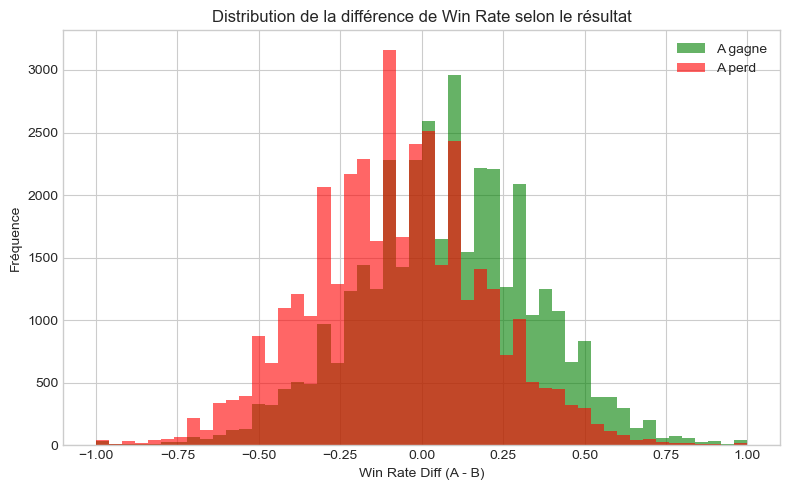

In [24]:
# Distribution de la différence de Win Rate
features_encoded['win_rate_diff'] = features_encoded['win_rate_a'] - features_encoded['win_rate_b']

fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['win_rate_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['win_rate_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('Win Rate Diff (A - B)')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution de la différence de Win Rate selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

Les victoires de A sont associées à des différences positives (A a un meilleur historique que B).

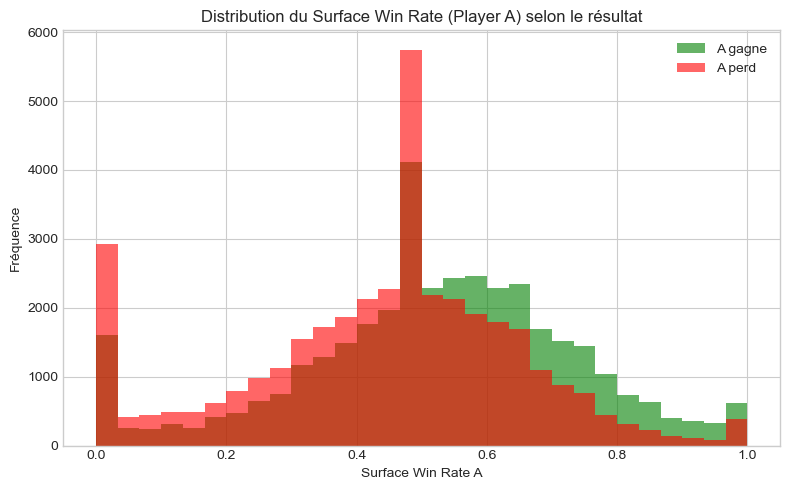

In [25]:
# Distribution du Surface Win Rate
fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['surface_win_rate_a'].hist(ax=ax, bins=30, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['surface_win_rate_a'].hist(ax=ax, bins=30, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('Surface Win Rate A')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution du Surface Win Rate (Player A) selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

La distribution est décalée vers la droite pour les victoires : un bon win rate sur la surface favorise la victoire.

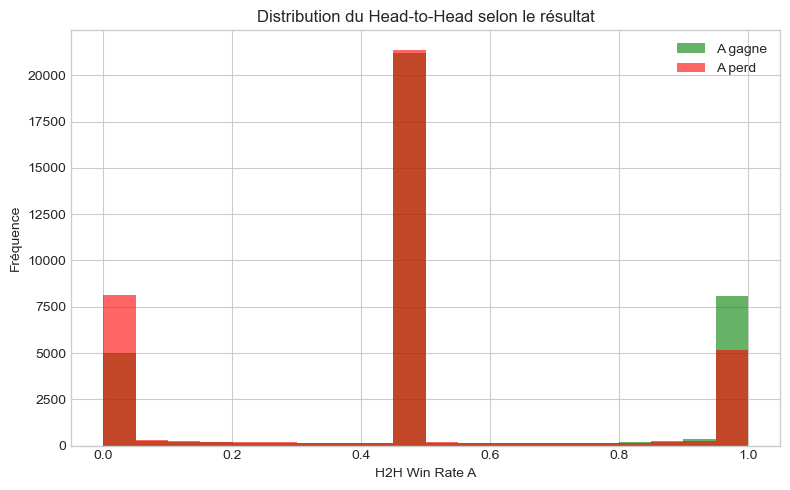

In [26]:
# Distribution du Head-to-Head
fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['h2h_win_rate_a'].hist(ax=ax, bins=20, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['h2h_win_rate_a'].hist(ax=ax, bins=20, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('H2H Win Rate A')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution du Head-to-Head selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

Beaucoup de matchs à 0.5 (pas d'historique), mais les valeurs hautes favorisent A


## 3.3 Taux de victoire selon le classement relatif

Analysons comment le taux de victoire varie en fonction de l'écart de classement.

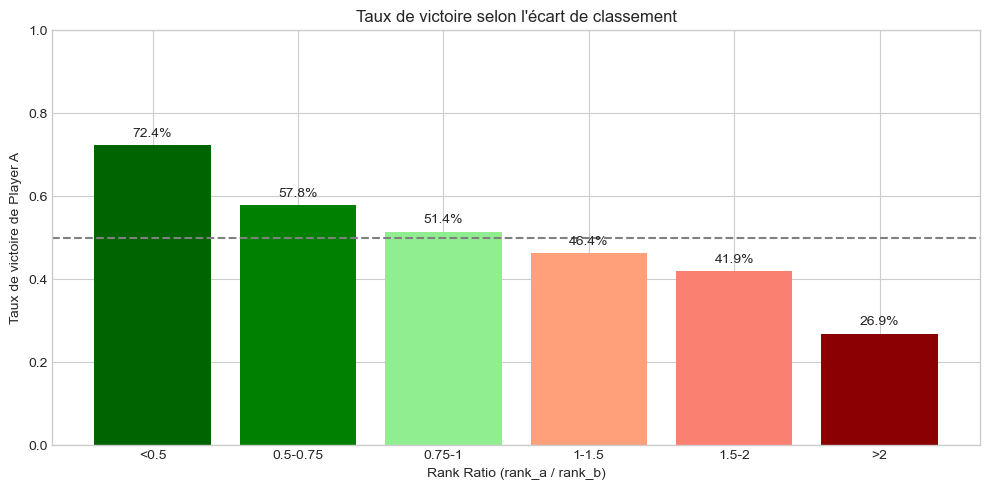

                Taux de victoire A  Nombre de matchs
rank_ratio_bin                                      
<0.5                      0.724037             23206
0.5-0.75                  0.578231              8085
0.75-1                    0.514404              6283
1-1.5                     0.463706              8693
1.5-2                     0.419310              5738
>2                        0.269114             22823


In [27]:
# Créer des bins pour le rank ratio
features_encoded['rank_ratio_bin'] = pd.cut(features_encoded['rank_ratio'], 
                                            bins=[0, 0.5, 0.75, 1, 1.5, 2, 100],
                                            labels=['<0.5', '0.5-0.75', '0.75-1', '1-1.5', '1.5-2', '>2'])

# Calculer le taux de victoire par bin
win_rate_by_rank = features_encoded.groupby('rank_ratio_bin', observed=True)['target'].agg(['mean', 'count'])
win_rate_by_rank.columns = ['Taux de victoire A', 'Nombre de matchs']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(win_rate_by_rank)), win_rate_by_rank['Taux de victoire A'], 
              color=['darkgreen', 'green', 'lightgreen', 'lightsalmon', 'salmon', 'darkred'])
ax.axhline(y=0.5, color='gray', linestyle='--', label='50%')
ax.set_xticks(range(len(win_rate_by_rank)))
ax.set_xticklabels(win_rate_by_rank.index)
ax.set_xlabel('Rank Ratio (rank_a / rank_b)')
ax.set_ylabel('Taux de victoire de Player A')
ax.set_title('Taux de victoire selon l\'écart de classement')
ax.set_ylim(0, 1)

# Ajouter les valeurs sur les barres
for i, (bar, val) in enumerate(zip(bars, win_rate_by_rank['Taux de victoire A'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(win_rate_by_rank)

**Observation clé** : Le classement est très prédictif :
- Quand rank_ratio < 0.5 (A est 2x mieux classé) → A gagne **72%** du temps
- Quand rank_ratio > 2 (A est 2x moins bien classé) → A gagne seulement **27%** du temps

Cela confirme que le classement ATP est une variable très discriminante.

---

## 3.5 Conclusion de l'analyse des features

### Ce que nous avons validé :

1. **Les features sont discriminantes** : les distributions diffèrent clairement entre victoires et défaites
2. **Pas de multicolinéarité parfaite** : les corrélations sont modérées (<0.8)
3. **Le classement est très prédictif** : le rank_ratio seul donne déjà une bonne indication
4. **Les features historiques apportent de l'information supplémentaire** : win rate, surface performance, H2H

### Attentes pour le modèle :

- Les features de **classement** (rank, points) devraient avoir les coefficients les plus significatifs
- Les features de **forme** (win_rate, surface_win_rate) devraient améliorer la baseline
- Certaines features comme **height** ou **is_left** pourraient être non-significatives

Nous validerons ces hypothèses dans la Partie 4 avec les p-values de la régression logistique.

---

# Partie 4 : Modélisation et Évaluation

Dans cette partie, nous allons :
1. Séparer les données en train/test
2. Entraîner une **régression logistique** (modèle interprétable)
3. Analyser les **coefficients et p-values** pour valider nos hypothèses
4. Comparer les performances à la baseline

## 4.1 Séparation Train / Test

Nous séparons les données en 80% train / 20% test. Comme nous avons randomisé l'attribution player_a/player_b, un split aléatoire est suffisant.

In [29]:
from sklearn.model_selection import train_test_split
from config import TEST_SIZE, RANDOM_STATE

# Nettoyer les colonnes temporaires créées pour l'analyse
cols_to_drop = ['win_rate_diff', 'rank_ratio_bin']
features_clean = features_encoded.drop(columns=[c for c in cols_to_drop if c in features_encoded.columns])

# Séparer features et target
X = features_clean.drop(columns=['target'])
y = features_clean['target']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train : {len(X_train):,} matchs")
print(f"Test  : {len(X_test):,} matchs")
print(f"Features : {X_train.shape[1]}")

Train : 60,012 matchs
Test  : 15,004 matchs
Features : 50


## 4.2 Rappel de la baseline

En Partie 1, nous avons calculé que **le joueur le mieux classé gagne ~65% des matchs**.

C'est notre référence : le modèle doit faire mieux que cette règle simple pour être utile.

## 4.3 Entraînement du modèle : Régression Logistique

Nous utilisons une **régression logistique** car :
- Elle est **interprétable** : chaque coefficient indique l'effet d'une variable
- Elle fournit des **p-values** : on peut tester la significativité statistique
- Elle est adaptée à la classification binaire

Nous utilisons `StatsLogitClassifier` de `src/training/models.py`, un wrapper autour de `statsmodels.Logit` qui donne accès aux p-values et intervalles de confiance.

In [30]:
from training.models import StatsLogitClassifier

# Entraîner le modèle
model = StatsLogitClassifier()
model.fit(X_train, y_train)

# Afficher le summary statistique
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                60012
Model:                          Logit   Df Residuals:                    59962
Method:                           MLE   Df Model:                           49
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                  0.1324
Time:                        23:45:21   Log-Likelihood:                -36087.
converged:                       True   LL-Null:                       -41597.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2375   6.85e+05  -3.47e-07      1.000   -1.34e+06    1.34e+06
rank_a                -0.0011   5.86e-05    -19.456      0.000      -0.001      -0.001
rank_b              

## 4.4 Analyse des coefficients et p-values

Le summary ci-dessus nous donne pour chaque variable :
- **coef** : l'effet sur le log-odds de victoire de player_a
- **P>|z|** : la p-value (significatif si < 0.05)

Extrayons les variables **statistiquement significatives** :

In [31]:
# Extraire les coefficients significatifs (p < 0.05)
significant = model.get_significant_features(alpha=0.05)
print(f"Variables significatives ({len(significant)}/{len(model.get_coefficients())-1}) :\n")
significant.sort_values('p_value')

Variables significatives (23/50) :



,coef,std_err,z,p_value,ci_lower,ci_upper
points_a,0.000254,0.000010,26.161706,7.252773e-151,0.000235,0.000274
points_b,-0.000272,0.000011,-24.225706,1.192625e-129,-0.000294,-0.000250
rank_b,0.001173,0.000059,19.989721,6.767313e-89,0.001058,0.001288
rank_a,-0.001140,0.000059,-19.456480,2.568312e-84,-0.001255,-0.001025
surface_win_rate_b,-0.839833,0.059615,-14.087642,4.524201e-45,-0.956676,-0.722990
surface_win_rate_a,0.768420,0.059866,12.835611,1.035819e-37,0.651084,0.885755
matches_played_b,-0.064323,0.005514,-11.665935,1.903000e-31,-0.075129,-0.053516
matches_played_a,0.061556,0.005560,11.072168,1.712075e-28,0.050660,0.072453
age_b,0.019378,0.002351,8.242508,1.686376e-16,0.014770,0.023986
h2h_win_rate_a,0.232724,0.030299,7.681013,1.578354e-14,0.173340,0.292109


### Interprétation et validation des hypothèses

Les résultats montrent **23 variables significatives sur 50**. Comparons avec nos hypothèses de la Partie 3 :

| Hypothèse (Partie 3) | Variables | Significative ? | Verdict |
|----------------------|-----------|-----------------|---------|
| Meilleur classement → victoire | `points_a/b`, `rank_a/b` | ✅ Oui (p ≈ 0) | **Validée** - Ce sont les 4 variables les plus significatives |
| Win rate élevé → victoire | `win_rate_a/b` | ✅ Oui | **Validée** - La forme récente compte |
| Bon sur la surface → victoire | `surface_win_rate_a/b` | ✅ Oui | **Validée** - Très forte significativité (5ème et 6ème) |
| H2H favorable → victoire | `h2h_win_rate_a` | ✅ Oui (p ≈ 1e-14) | **Validée** - L'historique des confrontations compte |
| Stats de service | `ace_rate`, `first_serve_won` | ✅ Oui | **Validée** - Le service est crucial |
| Taille / Main dominante | `height`, `is_left` | ❌ Non | **Non significatives** |

**Observations clés :**
- Les **points ATP** sont plus prédictifs que le rang brut (p-values plus faibles)
- Le **surface_win_rate** est très significatif : la spécialisation par surface compte vraiment
- Les variables physiques (`height`, `is_left`) et contextuelles (`round`, `surface`) ne sont **pas significatives**
- Le tour du tournoi (`round`) n'influence pas la probabilité de victoire

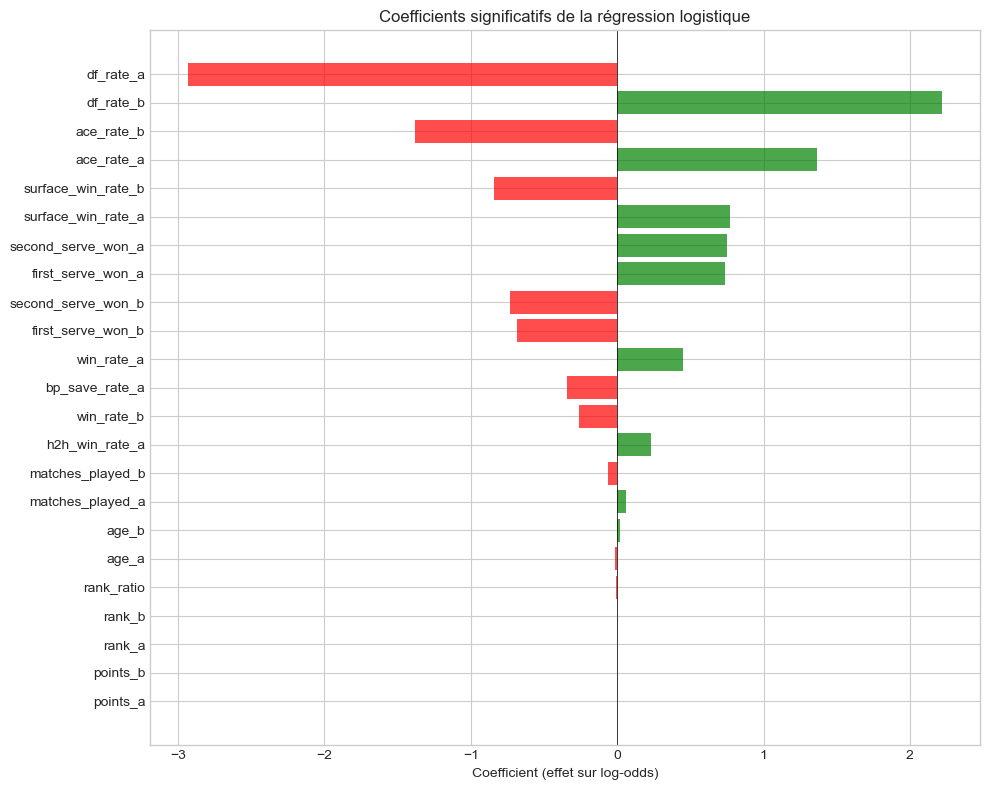

In [32]:
# Visualisation des coefficients significatifs
fig, ax = plt.subplots(figsize=(10, 8))

# Trier par valeur absolue du coefficient
sig_sorted = significant.reindex(significant['coef'].abs().sort_values(ascending=True).index)

colors = ['green' if c > 0 else 'red' for c in sig_sorted['coef']]
ax.barh(range(len(sig_sorted)), sig_sorted['coef'], color=colors, alpha=0.7)
ax.set_yticks(range(len(sig_sorted)))
ax.set_yticklabels(sig_sorted.index)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient (effet sur log-odds)')
ax.set_title('Coefficients significatifs de la régression logistique')

plt.tight_layout()
plt.show()

## 4.5 Évaluation du modèle

Évaluons les performances sur le jeu de test et comparons à la baseline.

In [33]:
from training.train import evaluate_model

# Évaluation sur le test set
metrics = evaluate_model(model, X_test, y_test)

# Baseline
baseline_pred = (X_test['rank_a'] <= X_test['rank_b']).astype(int)
baseline_acc = (baseline_pred == y_test).mean()

print("=" * 40)
print("RÉSULTATS SUR LE JEU DE TEST")
print("=" * 40)
print(f"\nModèle (Régression Logistique) :")
print(f"  Accuracy : {metrics['accuracy']:.1%}")
print(f"  Log Loss : {metrics['log_loss']:.4f}")
print(f"  ROC AUC  : {metrics['roc_auc']:.4f}")
print(f"\nBaseline (meilleur classement) :")
print(f"  Accuracy : {baseline_acc:.1%}")
print(f"\n→ Amélioration : +{(metrics['accuracy'] - baseline_acc) * 100:.1f} points")

RÉSULTATS SUR LE JEU DE TEST

Modèle (Régression Logistique) :
  Accuracy : 67.7%
  Log Loss : 0.5988
  ROC AUC  : 0.7400

Baseline (meilleur classement) :
  Accuracy : 66.4%

→ Amélioration : +1.3 points


---

## 4.6 Conclusion

### Résumé des résultats

| Métrique | Baseline | Modèle | Amélioration |
|----------|----------|--------|--------------|
| Accuracy | 66.4% | **67.7%** | +1.3 points |
| ROC AUC | - | 0.74 | - |

Notre modèle de régression logistique :
1. **Bat la baseline** de +1.3 points d'accuracy
2. **Identifie 23 variables significatives** sur 50
3. **Valide nos hypothèses** : classement, forme récente et surface sont les facteurs clés

### Variables les plus importantes (par ordre de significativité)

1. **Points ATP** (`points_a`, `points_b`) : le facteur le plus prédictif
2. **Classement** (`rank_a`, `rank_b`) : confirme l'importance du niveau
3. **Surface win rate** : la spécialisation par surface compte
4. **Win rate général** : la forme récente influence le résultat

### Limites et perspectives

- L'amélioration de +1.3 points est **modeste mais significative**
- Le tennis reste imprévisible : ~33% des matchs ne suivent pas la logique du classement
- Extensions possibles :
  - Comparer les probabilités du modèle aux cotes des bookmakers
  - Analyser les matchs où le modèle se trompe (upsets)
  - Tester d'autres algorithmes (Random Forest, XGBoost)